In [1]:
'''
Explanation of ground truth text file:

The text file contains lines of the form:

#ImgNo#.ppm;  #leftCol#;  ##topRow#;  #rightCol#;  #bottomRow#;  #ClassID#

for each traffic sign in the dataset. 

The first field refers to the image file the traffic sign is located in. 
Field 2 to 5 describe the region of interest (ROI) in that image.
ClassID is an integer number representing the kind of traffic sign.


'''


import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (32, 32)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [2]:
# range (1,1240)
# roothpath: cars

# Function for reading the images
def readImages_car(rootpath, images_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = [] # original image
    
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.jpg'
        
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        
        resize_2 = cv2.resize(img_resized, SIGN_SIZE)

        images.append(resize_2)
        
        
    return images



In [3]:
car_images = readImages_car('cars', range(1,1260))

In [4]:
# The German Traffic Sign Recognition Benchmark
'''
train_images: full road images
train_files: names of the full road images, ex. 'FullIJCNN2013/00091.ppm'
train_signs: images of the signs inside the full road images
train_bboxes: 4 coordinates of the ground-truth bboxes of the signs in each full road image
train_labels: sign class (0-42)
'''

'''
OJO: In the training set: 600 train_images --> with 852 train_signs
'''
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
#test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

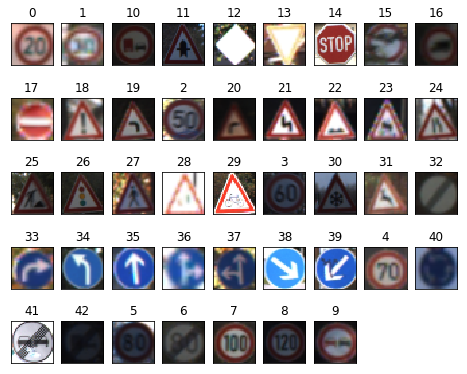

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

Using TensorFlow backend.


## Assignment

In [7]:
import pickle

# picke - loading
with open('train_pred.pickle', 'rb') as f:
    train_pred = pickle.load(f)

## Squares filters 

In [8]:
def filter_square(bbox):
    largo = abs(bbox[2]-bbox[0])
    ancho = abs(bbox[1]-bbox[3])
    proporcion = largo/ancho
    if(0.7 <= proporcion <= 1.3):
        return True
    else:
        return False
    
def filter_bigbox(bbox):
    largo = abs(bbox[2]-bbox[0])
    ancho = abs(bbox[1]-bbox[3])
    if(largo<150):
        return True 
    if(ancho<150):
        return True
    else:
        return False


In [9]:
len(train_pred['FullIJCNN2013/00045.ppm'][0])

1000

Largo: 231.475341796875
Ancho: 109.369384765625


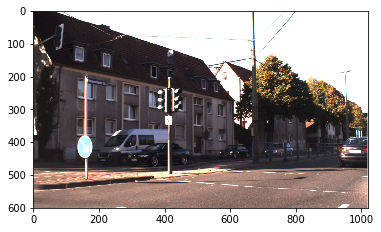

In [10]:
bbox_try = train_pred['FullIJCNN2013/00045.ppm'][0][0]

largo = abs(bbox_try[2]-bbox_try[0])
ancho = abs(bbox_try[1]-bbox_try[3])

print("Largo: {}".format(largo))
print("Ancho: {}".format(ancho))

for bbox in train_pred['FullIJCNN2013/00045.ppm'][0]:
    largo = abs(bbox_try[2]-bbox_try[0])
    ancho = abs(bbox_try[1]-bbox_try[3])
    proporcion = largo/ancho
    if(0.8 <= proporcion <= 1.2):
        cv2.rectangle(train_images['FullIJCNN2013/00045.ppm'][0], (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)
plt.imshow(cv2.cvtColor(train_images['FullIJCNN2013/00045.ppm'][0], cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
######## VARIABLES GUIDE

'''
dictionary_proposals: Dictionary with each file and its bbox proposals
dictionary_groundTruth: Dictionary with each file and its bbox ground-truth

background_bboxes_d: Dictionary Key-Filename, Value: Background bboxes
background_bboxes: List Background bboxes
background_files: List Background Files

proposedTruth_bboxes_d: Dictionary Key-Filename, Value: proposedTruth bboxes
proposedTruth_bboxes: List proposedTruth bboxes
proposedTruth_files: List proposedTruth Files

background_images: List with the images of the background

Binary Classifier: 1=signal 0= background

We need background images:

STEP 1: GET BACKGROUND BBOXES
STEP 2: CROP THOSE BBOXES FROM THE ORIGINAL IMAGES
STEP 3: DATA PREPARATION
STEP 4: DATA PREPROCESSING


groundTruth_labels: List of 1s
proposedTruth_labels: List of 1s
background_labels = List of 0s

bc_train_signs = Images for training the classifier (The sum of: train_signs + background_images)
bc_train_labels = Labels of the images (The sum of: groundTruth_labels + background_labels)
bc_train_bboxes = Bounding boxes of the signals in the bigger image (The sum of: train_bboxes + background_bboxes[0:len(background_images)])




'''

'\ndictionary_proposals: Dictionary with each file and its bbox proposals\ndictionary_groundTruth: Dictionary with each file and its bbox ground-truth\n\nbackground_bboxes_d: Dictionary Key-Filename, Value: Background bboxes\nbackground_bboxes: List Background bboxes\nbackground_files: List Background Files\n\nproposedTruth_bboxes_d: Dictionary Key-Filename, Value: proposedTruth bboxes\nproposedTruth_bboxes: List proposedTruth bboxes\nproposedTruth_files: List proposedTruth Files\n\nbackground_images: List with the images of the background\n\nBinary Classifier: 1=signal 0= background\n\nWe need background images:\n\nSTEP 1: GET BACKGROUND BBOXES\nSTEP 2: CROP THOSE BBOXES FROM THE ORIGINAL IMAGES\nSTEP 3: DATA PREPARATION\nSTEP 4: DATA PREPROCESSING\n\n\ngroundTruth_labels: List of 1s\nproposedTruth_labels: List of 1s\nbackground_labels = List of 0s\n\nbc_train_signs = Images for training the classifier (The sum of: train_signs + background_images)\nbc_train_labels = Labels of the imag

## STEP 1: GET BACKGROUND BBOXES

In [12]:
# Dictionary with each file and its bbox proposals

dictionary_proposals = {}
for filename in train_images: 
    dictionary_proposals[filename] = []
    bboxes = []
    for bbox in train_pred.get(filename)[0]:
        bboxes.append(bbox)
        #cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)
    dictionary_proposals[filename] = bboxes
    

In [13]:
train_bboxes[2]

array([289.5, 370.5, 331.5, 414. ])

In [14]:
# Dictionary with each file and its bbox ground-truth

dictionary_groundTruth = {}
for filename in train_images: 
    
    aux = train_images.get(filename)[0].copy()
    
    dictionary_groundTruth[filename] = []
    bboxes = []
    
    if filename in train_files:
        #print("si")
        # Para la cantidad de señales que haya en esta road image
        for idx in [i for i, x in enumerate(train_files) if x == filename]:
            # Coje las ground-truth bboxes
            bbox = train_bboxes[idx]
            bboxes.append(bbox)
    
    dictionary_groundTruth[filename] = bboxes
    
dictionary_groundTruth

{'FullIJCNN2013/00000.ppm': [array([580.5 , 308.25, 611.25, 334.5 ])],
 'FullIJCNN2013/00001.ppm': [array([737.25, 291.  , 768.  , 324.  ]),
  array([289.5, 370.5, 331.5, 414. ]),
  array([729.75, 251.25, 773.25, 292.5 ])],
 'FullIJCNN2013/00002.ppm': [array([669. , 357. , 754.5, 444. ])],
 'FullIJCNN2013/00003.ppm': [array([556.5 , 332.25, 573.75, 349.5 ]),
  array([556.5 , 349.5 , 573.  , 366.75]),
  array([552.75, 309.  , 576.75, 332.25])],
 'FullIJCNN2013/00004.ppm': [array([673.5 , 256.5 , 725.25, 306.75]),
  array([679.5 , 305.25, 716.25, 344.25])],
 'FullIJCNN2013/00005.ppm': [array([879. , 123. , 963. , 208.5])],
 'FullIJCNN2013/00006.ppm': [array([694.5 , 262.5 , 741.75, 310.5 ])],
 'FullIJCNN2013/00007.ppm': [array([618.75, 304.5 , 648.  , 333.75])],
 'FullIJCNN2013/00008.ppm': [array([588.75, 345.  , 608.25, 364.5 ]),
  array([584.25, 318.  , 612.  , 345.75])],
 'FullIJCNN2013/00009.ppm': [array([693.75, 349.5 , 711.75, 367.5 ])],
 'FullIJCNN2013/00010.ppm': [array([894.75, 

In [15]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

In [16]:
# background_bboxes:
# Dictionary: Filename - bbox
# Tiene que ser un dictionary para saber al hacer el crop a que imagen hacérsela
background_bboxes_d = {}
background_bboxes = []
background_files = []


# Bboxes proposed as signals because they have higher IOU than a threshold, dictionary por lo mismo
proposedTruth_bboxes_d = {}
proposedTruth_bboxes = []
proposedTruth_files = []

for filename in train_images:
    
    proposedTruth_bboxes_d[filename] = []
    background_bboxes_d[filename] = []
    
    boxes1 = dictionary_proposals[filename]
    boxes2 = dictionary_groundTruth[filename]
    
    bboxesHighIOU = []
    bboxesLowIOU  = []

    for bbox1 in boxes1:
        for bbox2 in boxes2:
            if(1 >= (bb_intersection_over_union(bbox1, bbox2)) > 0.85):
                bboxesHighIOU.append(bbox1)
                proposedTruth_bboxes.append(bbox1)
                proposedTruth_files.append(filename)
            if((bb_intersection_over_union(bbox1, bbox2)) == 0):
                bboxesLowIOU.append(bbox1)
                background_bboxes.append(bbox1)
                background_files.append(filename)
                
                
    
    proposedTruth_bboxes_d[filename] = bboxesHighIOU
    background_bboxes_d[filename] = bboxesLowIOU
                

In [17]:
len(background_bboxes)

659003

## STEP 2: CROP THOSE BBOXES FROM THE ORIGINAL IMAGES

In [18]:
def crop_bbox(img, bbox):
    
    
    #roi = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    #roi_resized = cv2.resize(roi, SIGN_SIZE)
    #roi_resized = roi_resized.astype('float32')
    #roi_resized /= 255.0
    #roi_resized = np.reshape(roi_resized, [1,SIGN_SIZE[0],SIGN_SIZE[1],3])
    #
    #return roi_resized
    
    scale = IMG_HEIGHT / float(img.shape[0])
    
    #Crop image
    cropped_image = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    #Resize image
    cropped_image_resized = cv2.resize(cropped_image, SIGN_SIZE)
    return cropped_image_resized

In [19]:
#background_images = []
#
#for bbox in background_bboxes_d['FullIJCNN2013/00000.ppm']:
#    background_images.append(crop_bbox(train_images[filename][0], bbox))

background_images = []
for filename in background_bboxes_d:
    print(filename)
    for bbox in background_bboxes_d[filename][0:100]:
        background_images.append(crop_bbox(train_images[filename][0], bbox))

FullIJCNN2013/00427.ppm
FullIJCNN2013/00189.ppm
FullIJCNN2013/00471.ppm
FullIJCNN2013/00237.ppm
FullIJCNN2013/00408.ppm
FullIJCNN2013/00188.ppm
FullIJCNN2013/00437.ppm
FullIJCNN2013/00138.ppm
FullIJCNN2013/00389.ppm
FullIJCNN2013/00168.ppm
FullIJCNN2013/00493.ppm
FullIJCNN2013/00319.ppm
FullIJCNN2013/00521.ppm
FullIJCNN2013/00447.ppm
FullIJCNN2013/00154.ppm
FullIJCNN2013/00572.ppm
FullIJCNN2013/00014.ppm
FullIJCNN2013/00122.ppm
FullIJCNN2013/00072.ppm
FullIJCNN2013/00155.ppm
FullIJCNN2013/00506.ppm
FullIJCNN2013/00261.ppm
FullIJCNN2013/00212.ppm
FullIJCNN2013/00414.ppm
FullIJCNN2013/00575.ppm
FullIJCNN2013/00578.ppm
FullIJCNN2013/00550.ppm
FullIJCNN2013/00424.ppm
FullIJCNN2013/00197.ppm
FullIJCNN2013/00310.ppm
FullIJCNN2013/00187.ppm
FullIJCNN2013/00061.ppm
FullIJCNN2013/00118.ppm
FullIJCNN2013/00366.ppm
FullIJCNN2013/00190.ppm
FullIJCNN2013/00440.ppm
FullIJCNN2013/00095.ppm
FullIJCNN2013/00362.ppm
FullIJCNN2013/00107.ppm
FullIJCNN2013/00024.ppm
FullIJCNN2013/00157.ppm
FullIJCNN2013/00

FullIJCNN2013/00144.ppm
FullIJCNN2013/00515.ppm
FullIJCNN2013/00526.ppm
FullIJCNN2013/00100.ppm
FullIJCNN2013/00452.ppm
FullIJCNN2013/00584.ppm
FullIJCNN2013/00450.ppm
FullIJCNN2013/00242.ppm
FullIJCNN2013/00247.ppm
FullIJCNN2013/00133.ppm
FullIJCNN2013/00083.ppm
FullIJCNN2013/00149.ppm
FullIJCNN2013/00010.ppm
FullIJCNN2013/00438.ppm
FullIJCNN2013/00038.ppm
FullIJCNN2013/00465.ppm
FullIJCNN2013/00076.ppm
FullIJCNN2013/00282.ppm
FullIJCNN2013/00029.ppm
FullIJCNN2013/00379.ppm
FullIJCNN2013/00304.ppm
FullIJCNN2013/00186.ppm
FullIJCNN2013/00444.ppm
FullIJCNN2013/00503.ppm
FullIJCNN2013/00462.ppm
FullIJCNN2013/00534.ppm
FullIJCNN2013/00226.ppm
FullIJCNN2013/00484.ppm
FullIJCNN2013/00368.ppm
FullIJCNN2013/00402.ppm
FullIJCNN2013/00448.ppm
FullIJCNN2013/00303.ppm
FullIJCNN2013/00177.ppm
FullIJCNN2013/00591.ppm
FullIJCNN2013/00561.ppm
FullIJCNN2013/00486.ppm
FullIJCNN2013/00131.ppm
FullIJCNN2013/00064.ppm
FullIJCNN2013/00278.ppm
FullIJCNN2013/00121.ppm
FullIJCNN2013/00585.ppm
FullIJCNN2013/00

In [20]:
len(background_images)

50600

In [21]:
#background_images = []
#
#for bbox in background_bboxes_d['FullIJCNN2013/00000.ppm']:
#    background_images.append(crop_bbox(train_images[filename][0], bbox))

proposedTruth_images = []
for filename in proposedTruth_bboxes_d:
    print(filename)
    for bbox in proposedTruth_bboxes_d[filename]:
        proposedTruth_images.append(crop_bbox(train_images[filename][0], bbox))

FullIJCNN2013/00427.ppm
FullIJCNN2013/00189.ppm
FullIJCNN2013/00471.ppm
FullIJCNN2013/00237.ppm
FullIJCNN2013/00408.ppm
FullIJCNN2013/00188.ppm
FullIJCNN2013/00437.ppm
FullIJCNN2013/00138.ppm
FullIJCNN2013/00389.ppm
FullIJCNN2013/00168.ppm
FullIJCNN2013/00493.ppm
FullIJCNN2013/00319.ppm
FullIJCNN2013/00521.ppm
FullIJCNN2013/00447.ppm
FullIJCNN2013/00154.ppm
FullIJCNN2013/00572.ppm
FullIJCNN2013/00014.ppm
FullIJCNN2013/00122.ppm
FullIJCNN2013/00072.ppm
FullIJCNN2013/00155.ppm
FullIJCNN2013/00506.ppm
FullIJCNN2013/00261.ppm
FullIJCNN2013/00212.ppm
FullIJCNN2013/00414.ppm
FullIJCNN2013/00575.ppm
FullIJCNN2013/00578.ppm
FullIJCNN2013/00550.ppm
FullIJCNN2013/00424.ppm
FullIJCNN2013/00197.ppm
FullIJCNN2013/00310.ppm
FullIJCNN2013/00187.ppm
FullIJCNN2013/00061.ppm
FullIJCNN2013/00118.ppm
FullIJCNN2013/00366.ppm
FullIJCNN2013/00190.ppm
FullIJCNN2013/00440.ppm
FullIJCNN2013/00095.ppm
FullIJCNN2013/00362.ppm
FullIJCNN2013/00107.ppm
FullIJCNN2013/00024.ppm
FullIJCNN2013/00157.ppm
FullIJCNN2013/00

In [22]:
'''

for image in background_images[0:200]:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
'''

'\n\nfor image in background_images[0:200]:\n    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))\n    plt.show()\n    \n'

In [23]:
from sklearn.utils import shuffle
N_BACKGROUND_IMAGES = 10000

len(background_images)
#len(proposedTruth_images)

background_images = shuffle(background_images)
background_images = background_images[0:N_BACKGROUND_IMAGES-1]


In [24]:
len(background_images)

9999

### Paint images

## STEP 3: DATA PREPARATION

In [25]:
## Bbox lists: 

# train_bboxes
# proposedTruth_bboxes
# background_bboxes

## Cathegory:

# 1 = signal
# 0 = background

train_signs_sum = train_signs + proposedTruth_images

# Labels:

groundTruth_labels = [1] * len(train_bboxes)
proposedTruth_labels = [1] * len(proposedTruth_bboxes)

background_labels = [0] * len(background_images)
car_background_labels = [0] * len(car_images)


bc_train_signs = train_signs_sum + background_images + car_images
bc_train_labels = groundTruth_labels + proposedTruth_labels + background_labels + car_background_labels

print("Lenght of signs: {}, composed by {} ground-truth and {} proposed truth".format(len(train_signs_sum), len(train_signs), len(proposedTruth_images)))
print("Background images: {} from proposed bboxes and {} from cars".format(len(background_images), len(car_images)))

print("Lenght of bc_train_signs: {}, composed by {} signals and {} background images".format(len(bc_train_signs), len(train_signs), len(background_images)))
print("Lenght of bc_train_labels: {}, composed by {} ground_truth, {} proposed truth, and {} background".format(len(bc_train_labels), len(groundTruth_labels), len(proposedTruth_labels), len(background_labels)))




Lenght of signs: 1009, composed by 852 ground-truth and 157 proposed truth
Background images: 9999 from proposed bboxes and 1259 from cars
Lenght of bc_train_signs: 12267, composed by 852 signals and 9999 background images
Lenght of bc_train_labels: 12267, composed by 852 ground_truth, 157 proposed truth, and 9999 background


In [26]:
len(groundTruth_labels)

852

1


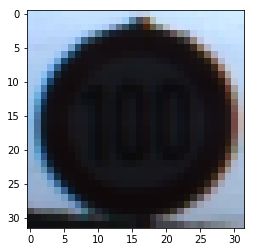

In [27]:



print(bc_train_labels[len(train_signs_sum)-1])
plt.imshow(cv2.cvtColor(bc_train_signs[len(train_signs_sum)-1], cv2.COLOR_BGR2RGB))
plt.show()
    

In [28]:
len(background_bboxes)

659003

## Step 4: Data preprocessing

In [44]:
# Randomly shuffle
from sklearn.utils import shuffle
bc_train_signs, bc_train_labels = shuffle(bc_train_signs, bc_train_labels)

# Divide train, dev, test set
from sklearn.model_selection import train_test_split

tr_signs, te_signs_aux, tr_labels, te_labels_aux = train_test_split(
    bc_train_signs, bc_train_labels, test_size=0.1, random_state=1)

te_signs, va_signs, te_labels, va_labels = train_test_split(
    te_signs_aux, te_labels_aux, test_size=0.5, random_state=1)

# List --> np.array
tr_signs = np.array(tr_signs)
tr_labels_np = np.array(tr_labels)

va_signs = np.array(va_signs)
va_labels_np = np.array(va_labels)

te_signs = np.array(te_signs)
te_labels_np = np.array(te_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

# Hot-encode classes
from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels_np, 2)
va_labels = np_utils.to_categorical(va_labels_np, 2)
te_labels = np_utils.to_categorical(te_labels_np, 2)

In [45]:
tr_labels_np[1]

0

### Number of samples using for Train, Dev, and Test

In [46]:
print("Training Set images: {}".format(len(tr_signs)))
print("Validation Test images: {}".format(len(va_signs)))
print("Test Set images: {}".format(len(te_signs)))

Training Set images: 11040
Validation Test images: 614
Test Set images: 613


### Image example and class

In [47]:
#for image in te_signs:
#    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#    plt.show()
#    #tr_labels[33]

## Binary Classifier Architecture

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam

cnn = Sequential()
cnn.add(Conv2D(filters=8, strides=(2, 2), kernel_size=(3, 3), padding='same', input_shape=(SIGN_SIZE[0], SIGN_SIZE[0], 3)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(filters=16, strides=(2, 2), kernel_size=(3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(filters=32, strides=(2, 2), kernel_size=(3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(filters=64, strides=(2, 2), kernel_size=(3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Flatten())
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(2))
cnn.add(Activation('sigmoid'))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 16, 8)         224       
_________________________________________________________________
activation_7 (Activation)    (None, 16, 16, 8)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 16)          1168      
_________________________________________________________________
activation_8 (Activation)    (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 32)          4640      
__________

## Train

In [49]:
print(np.unique(tr_labels))

[0. 1.]


In [50]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(tr_labels)
                                               ,tr_labels_np)

# With Image Generation

#from keras.preprocessing.image import ImageDataGenerator
#datagen = ImageDataGenerator(rotation_range=10,
#                              width_shift_range=0.1,
#                              height_shift_range=0.1,
#                              shear_range=0.01,
#                              zoom_range=[0.9, 1.25],
#                              horizontal_flip=False,
#                              vertical_flip=False,
#                              fill_mode='nearest',
#                              brightness_range=[0.5, 1.5])

#datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest', brightness_range=[0.5, 1.5])
#
#
#datagen.fit(tr_signs, augment=True)
#
train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
#
#data = cnn.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=16), epochs=5, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), class_weight = class_weights, validation_steps=valid_steps, callbacks=[tensorboard])



#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced'
#                                               ,np.unique(tr_labels)
#                                               ,tr_labels_np)
#
data = cnn.fit(tr_signs, tr_labels, batch_size=16, epochs=40, verbose=2, validation_data=(va_signs, va_labels), class_weight = class_weights, callbacks=[tensorboard])

Train on 11040 samples, validate on 614 samples
Epoch 1/40
 - 6s - loss: 0.2368 - acc: 0.9258 - val_loss: 0.1775 - val_acc: 0.9463
Epoch 2/40
 - 5s - loss: 0.1394 - acc: 0.9598 - val_loss: 0.1291 - val_acc: 0.9577
Epoch 3/40
 - 5s - loss: 0.1036 - acc: 0.9676 - val_loss: 0.1337 - val_acc: 0.9691
Epoch 4/40
 - 5s - loss: 0.0864 - acc: 0.9748 - val_loss: 0.1035 - val_acc: 0.9674
Epoch 5/40
 - 5s - loss: 0.0745 - acc: 0.9773 - val_loss: 0.0770 - val_acc: 0.9772
Epoch 6/40
 - 5s - loss: 0.0659 - acc: 0.9795 - val_loss: 0.0754 - val_acc: 0.9756
Epoch 7/40
 - 5s - loss: 0.0576 - acc: 0.9827 - val_loss: 0.0809 - val_acc: 0.9772
Epoch 8/40
 - 5s - loss: 0.0527 - acc: 0.9832 - val_loss: 0.0736 - val_acc: 0.9772
Epoch 9/40
 - 5s - loss: 0.0528 - acc: 0.9833 - val_loss: 0.0614 - val_acc: 0.9788
Epoch 10/40
 - 5s - loss: 0.0521 - acc: 0.9829 - val_loss: 0.0651 - val_acc: 0.9837
Epoch 11/40
 - 5s - loss: 0.0468 - acc: 0.9847 - val_loss: 0.0947 - val_acc: 0.9739
Epoch 12/40
 - 5s - loss: 0.0417 - ac

In [51]:
'''


from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

image_gen = ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

img_try = tr_signs[22]  

img_try = img.reshape((1,) + img.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in image_gen.flow(img_try, batch_size=1,
                          save_to_dir='preview_2', save_prefix='sign', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
        
        
'''

"\n\n\nfrom keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img\n\ndatagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')\n\nimage_gen = ImageDataGenerator(rotation_range=15,\n                               width_shift_range=0.1,\n                               height_shift_range=0.1,\n                               shear_range=0.01,\n                               zoom_range=[0.9, 1.25],\n                               horizontal_flip=True,\n                               vertical_flip=False,\n                               fill_mode='reflect',\n                               data_format='channels_last',\n                               brightness_range=[0.5, 1.5])\n\nimg_try = tr_signs[22]  \n\nimg_try = img.reshape((1,) + img.shape)  # this is a Numpy array with shape (1, 3, 150, 150)\n\n# the .flow() command below generates batches of randomly transformed images\n# and sa

In [52]:
'''

img = cv2.imread("preview_2/sign_0_461.jpeg", cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

'''

'\n\nimg = cv2.imread("preview_2/sign_0_461.jpeg", cv2.IMREAD_COLOR)\nplt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))\nplt.show()\n\n'

## Test

In [53]:
start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('')
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

from sklearn.metrics import confusion_matrix

print("Confusion matrix")

te_pred = cnn.predict_classes(te_signs)
confusion_matrix(te_labels_np, te_pred)


CNN took 0.0520472526550293 seconds
Test loss: 0.02408740133332748 - Accuracy: 0.9951060358890701
Confusion matrix


array([[556,   2],
       [  1,  54]])

In [55]:
cnn.save('binary_model_32.h5')  # creates a HDF5 file 'binary_model.h5'

### Missed classifications

In [40]:
#len(te_labels_np)
len(te_pred)

613

In [42]:
te_pred = cnn.predict_classes(te_signs)

In [ ]:
for image in list(range(len(te_signs)-1)):
    if(int(te_labels_np[image])!=int(te_pred[image])):
        print(image)
        print("The label was: {}, but predicted: {}".format(int(te_labels_np[image]), int(te_pred[image])))
        plt.imshow(cv2.cvtColor(te_signs[image], cv2.COLOR_BGR2RGB))
        plt.show()